In [1]:
from skimage.color import rgb2gray
import itertools as itt
from math import sqrt, hypot, log,sqrt
from numpy import arccos
import numpy as np
import math
import cv2
from time import time
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_laplace,gaussian_filter
image = cv2.imread("butterfly.jpg", cv2.IMREAD_GRAYSCALE)
import scipy.ndimage as ndi

In [2]:
#gaussian filter generation function
#parameter- standard deviation
def gaussianFilter(sigma):
    n=int(6*sigma)
    p=(n-1)//2
    fil=np.zeros((n,n))
    pi=3.14
    a=0
    b=0
    #looping from -p to p . gets middle value max
    for i in range(-1*p,p+1):
        b=0
        for j in range(-1*p , p+1):
            #gaussian filter formula
            val = math.exp(-1.0*((i)**2+(j)**2)/(2*sigma**2))
            fil[a][b] = 1-val
            b=b+1
        a+=1
        #return gaussian filter
    return fil

#laplacian of gaussian filter generation
def generateLOG(sigma):
    #as filter size must be atleast 6*sigma
    n=int(6*sigma)
    p=(n-1)//2
    l=np.zeros((n,n))
    pi=3.14
    m=0
    n=0
    for i in range(-1*p,p+1):
        n=0
        for j in range(-1*p , p+1):
            #log formula
            k=(i**2+j**2-(2*(sigma**2)))
            l[m][n]= k* math.exp(-1*(i**2+j**2)/(2*(sigma**2)))*(sigma**2)
            n=n+1
        m+=1
    #return laplacian of gaussian filter
    return l


# checking if those blobs are overlapping or not
# parameters - blobs which are being compared
def overlapping_blobs(blob_1, blob_2):
    root2 = sqrt(2)
    r1 = blob_1[2] * root2
    r2 = blob_2[2] * root2
    #distance formula
    d = hypot(blob_1[0] - blob_2[0], blob_1[1] - blob_2[1])
    #not overlapping
    if (d > r1 + r2):
        return 0
    #overlapping
    if (d <= abs(r1 - r2)):
        return 1
    
    #returning threshold value to check if they overlap or not
    #angle of intersection of blobs
    ratio_1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
    ratio_1 = np.clip(ratio_1, -1, 1)
    #inverse cosine
    acos_1 = arccos(ratio_1)
    #angle of intersection of blobs
    ratio_2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
    ratio_2 = np.clip(ratio_2, -1, 1)
    #inverse cosine
    acos_2 = arccos(ratio_2)
    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1
    area = r1 ** 2 * acos_1 + r2 ** 2 * acos_2 - 0.5 * sqrt(abs(a * b * c * d))
    return area / (math.pi * (min(r1, r2) ** 2))

#removing overlapping blobs
#parameters - blobs_array: coordinates of blobs and radius ,overlap:threshold
def blobs_pruning(blobs_array, overlap):
    for blob_1, blob_2 in itt.combinations(blobs_array, 2):
        #checking if the extent of overlap is greater than fixed threshold overlap
        if overlapping_blobs(blob_1, blob_2) > overlap:
            #removing blobs
            if blob_1[2] > blob_2[2]:
                blob_2[2] = -1
            else:
                blob_1[2] = -1
    return np.array([b for b in blobs_array if b[2] > 0])

#getting high intensity peaks
#parameters - image
def _extract_high_intensity_peaks(image, mask, numpeaks):
    
    #Return the highest intensity peak coordinates.
    # get coordinates of peaks
    coordinates = np.nonzero(mask)
    # select num_peaks peaks
    if len(coordinates[0]) > numpeaks:
        intensities = image[coordinates]
        idx = np.argsort(intensities)
        coordinates = np.transpose(coordinates)[idx][-numpeaks:]
    else:
        coordinates = np.column_stack(coordinates)
    # Highest peak first
    return coordinates[::-1]



#finding peak local maximum
def peak_local_max(image, mindistance=1, thresholdabs=None,
                   thresholdrel=None, exclude_border=True, indices=True,
                   num_peaks=np.inf, footprint=None, labels=None):
    # 2*mindistance+1 is the filter size, find max in this filter size
    if np.all(image == image.flat[0]):
        return np.empty((0, 2), np.int)

    # Non maximum filter
    image_max = ndi.maximum_filter(image, footprint=footprint,
                                       mode='constant')
    mask = image == image_max

    # find top peak candidates above a threshold
    thresholds = []
    thresholdabs = image.min()
    thresholds.append(thresholdabs)
    if thresholds:
        mask &= image > max(thresholds)

    # Select highest intensities (num_peaks)
    coordinates = _extract_high_intensity_peaks(image, mask, num_peaks)

    return coordinates


#non max suppression on image points
def Suppression_of_NONMAX(imagecube,sigmalist):
    #building (3,3,3) 3d filter to find maximum
    localmaxima = peak_local_max(imagecube,footprint=np.ones((3, 3, 3)),exclude_border=False)
    #float conversion
    lm = localmaxima.astype(np.float64)
    lm[:, 2] = sigmalist[localmaxima[:, 2]]
    #return coordinates with high intensity peaks
    return lm

#convolution code
def convolution(conv_img, filterType, w = 3):
    #shape of image
    n, m = conv_img.shape
    w = filterType.shape[0]
    #determining padding width
    conv_img = np.pad(conv_img,(int(w/2),int(w/2)),mode='constant')
    temp1=[]
    for i in range(n):
        temp=[]
        for j in range(m):
            # considering filter width patch in image
            k = conv_img[i:i+w, j:j+w]
            #pointwise multiplication
            val = np.multiply(k, filterType)
            #appending sum of convolution
            temp.append(np.sum(val))
        temp1.append(temp)
    #retruning result of convolution
    return np.array(temp1)

#Implementing difference of gaussian algorithm
def Difference_Of_Gaussian(image, min_sigma, max_sigma, sigma_ratio, threshold,overlap):
    #convert to float
    image = image.astype(np.float64)
    # k such that min_sigma*(sigma_ratio**k) > max_sigma
    k = int(log(float(max_sigma) / min_sigma, sigma_ratio)) + 1
    #generate sigma list
    sigma_list = np.array([min_sigma * (sigma_ratio ** i)for i in range(k + 1)])
    #generate gaussian filter and also convoluting it with image.
    gaussian_images = [gaussian_filter(image, s) for s in sigma_list]
    #calculating difference of gaussian images
    dog_images = [(gaussian_images[i] - gaussian_images[i + 1])* sigma_list[i] for i in range(k)]
    #stacking images
    image_cube = np.dstack(dog_images)
    print(image_cube.shape)
    #calling Nonmaxsuppression function
    local_maxima =Suppression_of_NONMAX(image_cube,sigma_list)
    print(local_maxima.shape)
    return blobs_pruning(local_maxima, overlap)


#Implementing laplacian of gaussian algorithm
def Laplacian_Of_Gaussian(image, min_sigma, max_sigma, num_sigma, threshold,overlap):
    #convert to float
    image = image.astype(np.float64)
    #generate sigma list
    sigma_list = np.linspace(min_sigma, max_sigma, num_sigma)   
    l=[]
    #generating scale space image cube
    for i in range(len(sigma_list)):
        #calling convolveSobel function
        conv1=convolution(image,generateLOG(sigma_list[i]),1)
        conv2=conv1**2
        l.append(conv2)
    #plotting them
#     for i in range(len(sigma_list)):
#         plt.imshow(l[i],cmap="gray")
#         plt.figure()
    
    #stacking images
    image_cube = np.dstack(l)
    print(image_cube.shape)
    #calling NonmaxSuppression function
    local_maxima=Suppression_of_NONMAX(image_cube,sigma_list)
    print(local_maxima.shape)
    return blobs_pruning(local_maxima, overlap)

(356, 493, 10)
(205, 3)
log time:47.7970187664032
(356, 493, 6)
(866, 3)
dog time:1.9854111671447754


C:\Users\lenovo\AppData\Local\conda\conda\envs\jup\lib\site-packages\matplotlib\axes\_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


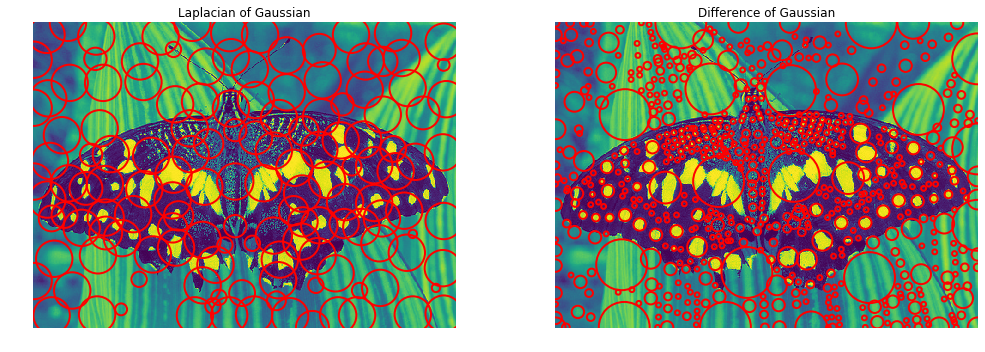

In [3]:
#converting rgb to gray scale image
image_gray = rgb2gray(image)

#calculate initial time(before laplacian of gaussian)
t0_1 = time()

#function calling of laplacian of gaussian
# parameters -(image,sigma initial value,sigma final value,no. of sigmas,overlap)
b_log = Laplacian_Of_Gaussian(image,2,15,10,1.25,0.5)

#time after log
t1_1 = time()

#runtime of log
log_time = t1_1 - t0_1 #log_time in seconds******************
print("log time:"+ str(log_time))

#calculating radius  r=sqrt(2)*sigma
b_log[:, 2] = b_log[:, 2] * sqrt(2)

# initial time of difference of Gaussian
t0_2 = time()

#function calling of difference of gaussian
b_dog = Difference_Of_Gaussian(image,2,30,1.6,2,0.5)

#time after dog
t1_2 = time()

#runtime of dog
dog_time = t1_2 - t0_2 #dog_time in seconds*******************
print("dog time:"+ str(dog_time))

# calculating radius
b_dog[:,2]= b_dog[:,2] * sqrt(2)

# steps for plotting

#co-ordinates and radius of blobs according to dog and log
blobs_list = [b_log, b_dog]

#titles
c =['black', 'black']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',]
sequence = zip(blobs_list, c, titles)

#subplotting
fig, angles = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
plot = angles.ravel()

#plotting images
for i, (blobs, color, title) in enumerate(sequence):
    plot[i].set_title(title)
    plot[i].imshow(image_gray)
    for blob in blobs:
        #extracting coordinates and radius of blobs
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        plot[i].add_patch(c)
    plot[i].set_axis_off()
plt.tight_layout()
plt.show()